# Stochastic Gradient Descent

Consider a function that depends on a number of variables $\vec{x}$ and parameters ${\bf w}$,
$$
f_{ {\bf w} }(\vec{x} ) \;,
$$
with the parameters not only affecting the values of the function but  **defining** it (e.g. consider $f_{a}(x) = x^a$).  Consider also another function that depends on $f_{\bf w}$, but not $\vec{x}$ (e.g. by averaging over $\vec{x}$), i.e. $E[f_{\bf w}]$. How do we minimize $E[f_{\bf w}]$? This can be done by taking  $E({\bf w})=E[f_{\bf w}]$, and using (for example) *Gradient Descent* (GD) to find ${\bf w}$ that minimize $E$.

In the case of $E[f_{\bf w}] = \dfrac{1}{n}\displaystyle \sum_{i=0}^{n} Q[ f_{\bf w}(\vec{x}_i)]$, GD becomes (in principle) very expensive as $n \to \infty$, as the parameters are updated using 
$$
{\bf w}^{\prime} = {\bf w} - \alpha {\bf \nabla}_{\bf w} E[f_{\bf w}] \Rightarrow \\
%
{\bf w}^{\prime} = {\bf w} - \dfrac{\alpha}{n} {\bf \nabla}_{\bf w} \displaystyle\sum_{i}^{n} Q[f_{\bf w}(\vec{x})_i] \; ,
$$
i.e. we need to compute the sum at each step. 

However, instead of computing the sum at each step, we can randomly choose a point $\vec{x}_i$, and update ${\bf w}$ using
$$
{\bf w}^{\prime} = {\bf w} - \alpha {\bf \nabla}_{\bf w} Q[f_{\bf w}(\vec{x})_i] \; .
$$
This is the *Stochastic Gradient Descent* (SGD) algorithm. The idea here is that after $N$ updates, as $N \to \infty$, the steps converge to $\Delta{\bf w}= - \dfrac{\alpha}{N} \displaystyle\sum_{i}^{N}{\bf \nabla}_{\bf w} Q[f_{\bf w}(\vec{x})_i] \approx -\alpha {\bf \nabla}_{\bf w} E[f_{\bf w}]$.


Let's see how it works, by constructing a class!


In order to make it consistent  with the GD algorithm, we will use the definition
$$
Q[f_{\bf w}(\vec{x})] \equiv Q(\vec{x};{\bf w}) \;,
$$
which results to (the $t^{\rm th}$ update)
$$
{\bf w}^{(t+1)} = {\bf w}^{(t)} - \alpha {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t)}) \;,
$$
for $\vec{x}_i$ random from $\{\vec{x}_1, \vec{x}_2, \dots ,\vec{x}_n \}$.


# AdaDelta


One of the things that can make SGD unable to converge, is the learning rate, which has to be tunned. This can be avoided by using *AdaDelta* [[1212.5701](https://arxiv.org/abs/1212.5701)] that tries to adjust the learning as the algorithm proceeds. 

The update of ${\bf w}$, according to this is: 

$$
{\bf w}^{(t)} = {\bf w}^{(t-1)} - \delta {\bf w}^{(t)}  \;,
$$
with
$$
\delta {\bf w}^{(t)} = \dfrac{\sqrt{ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} + \epsilon}  }{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \;, 
$$
where the *decaying averages* are
$$
\mathbb{E}[\delta {\bf w}^2]^{(t)} \equiv \gamma \ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} +
(1-\gamma) \ \left( \delta {\bf w}^{(t)} \right)^2 \;, 
\\
\mathbb{E}[g^2]^{(t)} \equiv \gamma \ \mathbb{E}[g^2]^{(t-1)} +
(1-\gamma) \ \left( {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \right) \cdot \left( {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \right)\;, 
$$
for $\mathbb{E}[X]^{(0)} = 0$. 

The parameters $\gamma$ and $\epsilon$ are free, but generally $\gamma \approx 1$ and $\epsilon \ll 1$. Common choice is $\gamma \approx 0.95$ and $\epsilon \ll 10^{-6}$.

### The algorithm

With these definitions, the AdaDelta algorithm is:

1. Initialize $\mathbb{E}[g^2]^{(0)} =0$ and $\mathbb{E}[\delta {\bf w}^2]^{(0)}=0$
1. Loop t=1,2,...  until some condition is satisfied
    1. Calculate ${\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)})$
    1. Accumulate $\mathbb{E}[g^2]^{(t)}$
    1. Calculate $\delta {\bf w}^{t} = \dfrac{\sqrt{ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} + 
    \epsilon}  }{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)})$
    1. Accumulate $\mathbb{E}[\delta {\bf w}^2]^{(t)}$
    1. Update ${\bf w}^{(t+1)} = {\bf w}^{(t)} - \delta {\bf w}^{(t)}$  
1. Done

---

## RMSprop

There is a variant of AdaDelta called *RMSprop*, which uses
$$
\delta {\bf w}^{(t)} = \dfrac{\alpha}{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \;, 
$$
with $\alpha \ll 1$ some constant (typically $\alpha  =10^{-3}$).


In [1]:
import numpy as np


import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
class targetFunc:
    '''
    This is how the function should look like.
    The key point is to have way to update the parameters w.
    '''
    def __init__(self,func,w0):
        self.f=func
        self.w=w0
        self.dim=len(w0)
    
    
    
    def __call__(self,x):
        return self.f(self,x)
    
        
class lossFunc:
    '''
    This is how the loss function should look like.
    We use a class, in order to encapsulate the gradient within the same object.
    '''
    def __init__(self,loss,target):
        self.Q=loss
        self.targetFunc=target
        
        self.dim=len(self.targetFunc.w)
            
    def __call__(self,x,t):

        return self.Q(self.targetFunc,x,t)
        
 
    
    def Grad(self,x,t,h=1e-5):
        grad=[]
        for dim in range(self.dim):
            
            self.targetFunc.w[dim]-=h
            dQdw0=self(x,t)

            self.targetFunc.w[dim]+=2*h
            dQdw1=self(x,t) 
            
            self.targetFunc.w[dim]-=h

            grad.append((dQdw1-dQdw0)/(2*h))

        return grad


In [3]:
class StochasticGradientDescent:    
    def __init__(self,strategy):
        self.strategy=strategy
    
    
    
    
    def run(self,abs_tol=1e-5, rel_tol=1e-3, step_break=100,max_step=5000):
        '''        
        abs_tol, rel_tol, step_break: stop when _check<1 (_check is what update should return) 
        for step_break consecutive steps
        
        max_step: maximum number of steps
        '''
        _s=0
        count_steps=1
        while count_steps<=max_step:
            _check=self.strategy.update(abs_tol, rel_tol)
            
            count_steps+=1             
                
            
            if _check<1:
                _s+=1
            else:
                _s=0
            
            if _s>step_break:
                break

        return self.strategy.lossFunc.targetFunc.w[:]

In [4]:
class VanillaSGD:
    '''Plain SGD, with constant learning rate'''
    
    def __init__(self,loss,data,alpha=1e-2):
        '''
        loss: the loss function
        data: the data to be used in order to minimize the loss
        alpha: the learning rate
        '''
        
        self.lossFunc=loss
        self.data=data
        self.alpha=alpha

        self.data_size=len(self.data)
        self.steps=[]
        self.steps.append(self.lossFunc.targetFunc.w[:])
        self.dim=self.lossFunc.targetFunc.dim

    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        
        index=np.random.randint(self.data_size)
        x=self.data[index][0]
        t=self.data[index][1]
        grad=self.lossFunc.Grad(x,t)            

        _w2=0
        _check=0
        for i,g in enumerate(grad):
            self.lossFunc.targetFunc.w[i]=self.lossFunc.targetFunc.w[i]-self.alpha*g
            
            _w2=abs_tol + self.lossFunc.targetFunc.w[i] * rel_tol
            _check+=(g/_w2)*(g/_w2)

        _check=np.sqrt(1./self.dim *_check)
        
        self.steps.append(self.lossFunc.targetFunc.w[:])
        
        
        return _check

In [5]:
class RMSpropSGD:
    '''Implementation of RMSprop.'''

    def __init__(self,loss,data,gamma=0.95,epsilon=1e-6,alpha=1e-3):
        '''
        loss: the loss function
        data: the data to be used in order to minimize the loss
        gamma: the decaying parameter
        epsilon: safety parameter (to avoid division by 0)
        alpha: learning rate
        '''
        
        self.lossFunc=loss
        self.data=data
        self.gamma=gamma
        self.epsilon=epsilon
        self.alpha=alpha
        
        self.data_size=len(self.data)
        self.steps=[]
        self.steps.append(self.lossFunc.targetFunc.w[:])
        self.dim=self.lossFunc.targetFunc.dim
        
        # counters for the decaying means of the gradient and dw         
        self.gE=[0 for _ in self.lossFunc.targetFunc.w]

    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        index=np.random.randint(self.data_size)
        x=self.data[index][0]
        t=self.data[index][1]
        grad=self.lossFunc.Grad(x,t)            

        
        
        _w2=0
        _check=0
        for i,g in enumerate(grad):
            self.gE[i]=self.gamma*self.gE[i] + (1-self.gamma)*g**2 
            dw=self.alpha/np.sqrt( (self.gE[i]+self.epsilon)  )*g
            
            
            self.lossFunc.targetFunc.w[i]=self.lossFunc.targetFunc.w[i] - dw
            
            
            _w2=abs_tol + self.lossFunc.targetFunc.w[i] * rel_tol
            _check+=(g/_w2)*(g/_w2)

        _check=np.sqrt(1./self.dim *_check)
        self.steps.append(self.lossFunc.targetFunc.w[:])
        
        return _check

In [6]:
class AdaDeltaSGD:
    '''Implementation of AdaDelta.'''
    
    def __init__(self,loss,data,gamma=0.95,epsilon=1e-6,alpha=1):
        '''
        loss: the loss function
        data: the data to be used in order to minimize the loss
        gamma: the decaying parameter
        epsilon: safety parameter (to avoid division by 0)
        '''
        self.lossFunc=loss
        self.data=data
        self.gamma=gamma
        self.epsilon=epsilon
        self.alpha=alpha
        
        self.data_size=len(self.data)
        self.steps=[]
        self.steps.append(self.lossFunc.targetFunc.w[:])
        self.dim=self.lossFunc.targetFunc.dim
        
        # counters for the decaying means of the gradient and dw         
        self.gE=[0 for _ in self.lossFunc.targetFunc.w]
        self.dwE=[0 for _ in self.lossFunc.targetFunc.w]
        
        #lists to store the changes in w         
        self.dw=[0 for _ in self.lossFunc.targetFunc.w]

    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        index=np.random.randint(self.data_size)
        x=self.data[index][0]
        t=self.data[index][1]
        grad=self.lossFunc.Grad(x,t)            

        
        _w2=0
        _check=0
        for i,g in enumerate(grad):
            self.gE[i]=self.gamma*self.gE[i] + (1-self.gamma)*g**2 
            self.dw[i]=np.sqrt( (self.dwE[i]+self.epsilon)/(self.gE[i]+self.epsilon)  )*g*self.alpha
            
            self.dwE[i]=self.gamma*self.dwE[i] + (1-self.gamma)*self.dw[i]**2
            
            self.lossFunc.targetFunc.w[i]=self.lossFunc.targetFunc.w[i] - self.dw[i]
            
            
            _w2=abs_tol + self.lossFunc.targetFunc.w[i] * rel_tol
            _check+=(g/_w2)*(g/_w2)

        _check=np.sqrt(1./self.dim *_check)
        
        self.steps.append(self.lossFunc.targetFunc.w[:])
        
        return _check


# Example

Lets find $w_1$ and $w_2$ for $f(x) = x w_1+ w_2$ that fit with data taken from $t=2*x+3$.

Obviously the answer is $w_1 = 2$ and $w_2 = 3$.

In [7]:
def testFunc(self,x):
    return [x[0]*self.w[0]+ self.w[1]]

def SME_loss(f,x,t):
    return np.mean([(f(x)[i] - _t)**2 for i,_t in enumerate(t)])

In [8]:
f=targetFunc(testFunc,[0.2,-2])
Q=lossFunc(SME_loss,f)


data=[]
xmin=-5
xmax=2
for i in range(20000):
    x=np.random.rand()*(xmax-xmin)+xmin
    data.append( [[x],[2*x+3 ]])

# strategy=VanillaSGD(Q ,data,alpha=1e-2)
strategy=RMSpropSGD(Q ,data,gamma=1-1e-2,epsilon=1e-5,alpha=1e-1)
# strategy=AdaDeltaSGD(Q ,data,gamma=0.99,epsilon=1e-5,alpha=1)


In [9]:
SGD=StochasticGradientDescent(strategy)

In [10]:
SGD.run(abs_tol=1e-5, rel_tol=1e-3, step_break=1000,max_step=5000),len(strategy.steps)

([2.0, 3.0], 1512)

<IPython.core.display.Javascript object>


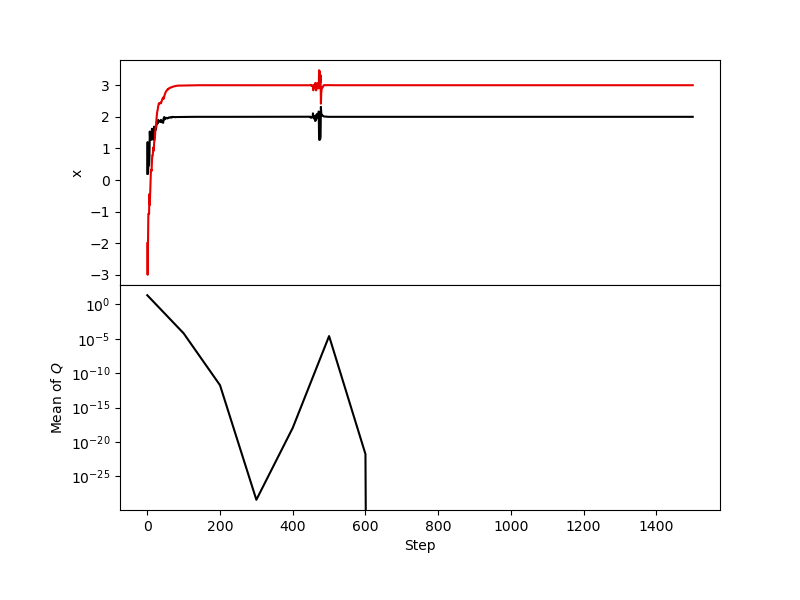

In [11]:
fig=plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.get_xaxis().set_visible(False)

sub.plot(np.array(strategy.steps)[:,0],c='xkcd:black')
sub.plot(np.array(strategy.steps)[:,1],c='xkcd:red')

sub.set_ylabel('x')
# sub.set_xscale('log')
sub.set_yscale('linear')


sub = fig.add_subplot(212)
meanQ=[]
steps=[]
_s=0
skip=100
for w in strategy.steps[::skip]:
    f.w=w
    mQ=0
    _r=range(len(data))
    mC=50
    for _ in range(mC): 
        i=np.random.choice(_r)
        mQ+=Q(data[i][0], data[i][1]) 
    meanQ.append(mQ/mC)
    steps.append(_s)
    _s+=skip
    
sub.plot(steps,meanQ,c='xkcd:black')

sub.set_ylabel('Mean of $Q$')

# sub.set_xscale('log')
sub.set_yscale('log')

sub.set_xlabel('Step')

plt.show()

# Function approximation

The observation above can be used to find approximations of a function. For example, consider the problem of finding an approximation of a function that obeys $G_1[f(\vec{x})] = G_2[f(\vec{x})]$ (inside a given region of $\vec{x}$). We could, then, define $f_{\bf w}(\vec{x})$, and minimize $E[f_{\bf w}] = \dfrac{1}{n}\displaystyle \sum_{i=0}^{n} Q[ f_{\bf w}(\vec{x}_i)]$ (for a lot of points in the region of interest) with $Q=(G_1 - G_2)^2$ by and adjusting ${\bf w}$ following SGD. As $n \to \infty$, we should end up with a set of ${\bf w}$ that define a function with $G_1[f_{\bf w}(\vec{x})] \approx G_2[f_{\bf w}(\vec{x})]$.


Notice that if we only generated data when needed, we could skip the initial generation of $n$ points.

# Example

Let's try to find $f(x)$ so that $f(x)=1/f(x)$ $x \in [-1,1]$. To do this we define $Q[f_{\bf w}]=\Big(f_{\bf w}(x)-1/f_{\bf w}(x) \Big)^2$.

To do this, we define $f_{\bf w} \equiv w_0 x + w_1$. Since the answer is $f(x)= \pm 1$, we expect $w_0=0$ and $w_1 = \pm 1$.

In [12]:
def testFunc(self,x):
    return [x[0]*self.w[0]+ self.w[1]]

def SME_loss(f,x,t):
    return np.mean([(f(x)[i] - 1/(f(x)[i]))**2 for i,_t in enumerate(t)])

In [13]:
f=targetFunc(testFunc,[-0.2,0.5])
Q=lossFunc(SME_loss,f)


data=[]
xmin=-1
xmax=1
for i in range(5000):
    x=np.random.rand()*(xmax-xmin)+xmin
    data.append( [[x],[0]])

    

# strategy=VanillaSGD(Q ,data,alpha=1e-3)
strategy=RMSpropSGD(Q ,data,gamma=1-1e-3,epsilon=1e-3,alpha=0.1)
# strategy=AdaDeltaSGD(Q ,data,gamma=1-1e-3,epsilon=1e-3,alpha=1)

In [14]:
SGD=StochasticGradientDescent(strategy)
SGD.run(abs_tol=1e-5, rel_tol=1e-3, step_break=500,max_step=15000),len(strategy.steps)

([-1.5826229776229004e-11, 1.000000000071655], 566)

<IPython.core.display.Javascript object>


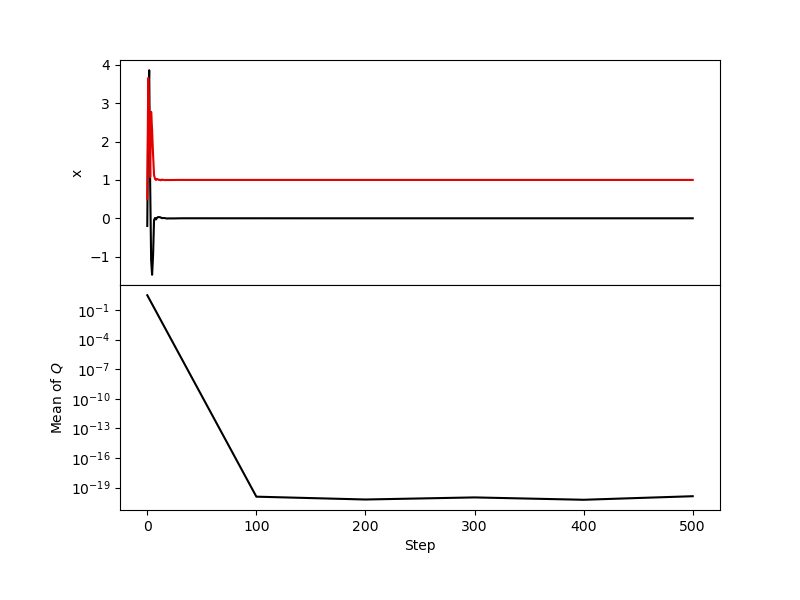

In [15]:
fig=plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.get_xaxis().set_visible(False)

sub.plot(np.array(strategy.steps)[:,0],c='xkcd:black')
sub.plot(np.array(strategy.steps)[:,1],c='xkcd:red')

sub.set_ylabel('x')
# sub.set_xscale('log')
sub.set_yscale('linear')


sub = fig.add_subplot(212)
meanQ=[]
steps=[]
_s=0
skip=100
for w in strategy.steps[::skip]:
    f.w=w
    mQ=0
    _r=range(len(data))
    mC=50
    for _ in range(mC): 
        i=np.random.choice(_r)
        mQ+=Q(data[i][0], data[i][1]) 
    meanQ.append(mQ/mC)
    steps.append(_s)
    _s+=skip
    
sub.plot(steps,meanQ,c='xkcd:black')

sub.set_ylabel('Mean of $Q$')

# sub.set_xscale('log')
sub.set_yscale('log')

sub.set_xlabel('Step')

plt.show()